# Step 1: 
### Load the Data We load the two datasets: 
#### Internal_trade_data.xlsx: Contains monthly outright trades and a quarterly contract with columns trade_id, contract_type, contract_period, quantity_mwh, price_eur_per_mwh.
#### clearer_trade_data.xlsx: Contains the clearer's monthly settled positions with columns delivery_month, quantity_mwh, price_eur_per_mwh.
#### I rename delivery_month to contract_period in the clearer data for consistency when merging.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load internal trade data
internal_df = pd.read_excel('internal_trade_data.xlsx')

# Load clearer trade data
clearer_df = pd.read_excel('clearer_trade_data.xlsx')

# Rename delivery_month to contract_period for consistency
clearer_df = clearer_df.rename(columns={'delivery_month': 'contract_period'})

In [5]:
internal_df.head()

,trade_id,contract_type,contract_period,quantity_mwh,price_eur_per_mwh
0,1,Outright,2025-03,100,30
1,2,Outright,2025-04,200,31
2,3,Outright,2025-05,250,32
3,4,Outright Quarter,Q225,300,33


In [7]:
clearer_df.tail()

,contract_period,quantity_mwh,price_eur_per_mwh
0,2025-03,100,30.0
1,2025-04,500,32.0
2,2025-05,550,32.5
3,2025-06,300,33.0


# Step 2: Decompose the Quarterly Contract
#### The quarterly contract (Q225) covers April, May, and June 2025. We split it into three equal monthly parts:
#### Total quantity is divided by 3 (e.g., 300 MWh ÷ 3 = 100 MWh per month).
#### The price remains unchanged (€33).
#### We create a new DataFrame (quarterly_splits) with columns contract_period, quantity_mwh, and price_eur_per_mwh for these monthly parts.

In [9]:
# Identify quarterly trades
quarterly_df = internal_df[internal_df['contract_type'] == 'Outright Quarter']

# Split quarterly trade into monthly parts (Apr, May, Jun for Q225)
if not quarterly_df.empty:
    quarterly_trade = quarterly_df.iloc[0]
    total_quantity = quarterly_trade['quantity_mwh']
    total_price = quarterly_trade['price_eur_per_mwh']
    monthly_periods = ['2025-04', '2025-05', '2025-06']
    quantity_per_month = total_quantity / len(monthly_periods)
    
    quarterly_splits = pd.DataFrame({
        'contract_period': monthly_periods,
        'quantity_mwh': [quantity_per_month] * len(monthly_periods),
        'price_eur_per_mwh': [total_price] * len(monthly_periods)
    })
else:
    quarterly_splits = pd.DataFrame(columns=['contract_period', 'quantity_mwh', 'price_eur_per_mwh'])

In [11]:
quarterly_splits

,contract_period,quantity_mwh,price_eur_per_mwh
0,2025-04,100.0,33
1,2025-05,100.0,33
2,2025-06,100.0,33


# Step 3: Combine Internal Trades
#### I combine the monthly outright trades with the decomposed quarterly trades:
#### Extract monthly outright trades (contract_type = 'Outright') with columns contract_period, quantity_mwh, price_eur_per_mwh.
#### Concatenate with the quarterly splits to form all_internal_trades.
#### Add a value column (quantity_mwh × price_eur_per_mwh) for calculating weighted average prices.



In [13]:
# Get monthly outright trades
monthly_outright = internal_df[internal_df['contract_type'] == 'Outright'][['contract_period', 'quantity_mwh', 'price_eur_per_mwh']]

# Combine monthly outright and quarterly splits
all_internal_trades = pd.concat([monthly_outright, quarterly_splits], ignore_index=True)

# Calculate value
all_internal_trades['value'] = all_internal_trades['quantity_mwh'] * all_internal_trades['price_eur_per_mwh']

In [15]:
all_internal_trades

,contract_period,quantity_mwh,price_eur_per_mwh,value
0,2025-03,100.0,30,3000.0
1,2025-04,200.0,31,6200.0
2,2025-05,250.0,32,8000.0
3,2025-04,100.0,33,3300.0
4,2025-05,100.0,33,3300.0
5,2025-06,100.0,33,3300.0


# Step 4: Calculate Net Internal Positions
#### For each month, we net the internal positions by:
#### Grouping by contract_period.
#### Summing quantity_mwh and value.
#### Calculating the average price as sum(value) / sum(quantity_mwh).
#### This results in a DataFrame (net_internal) with columns contract_period, quantity_mwh, and average_price.

In [17]:
# Group by contract_period to get net positions
net_internal = all_internal_trades.groupby('contract_period').agg({
    'quantity_mwh': 'sum',
    'value': 'sum'
}).reset_index()

# Calculate average price
net_internal['average_price'] = net_internal['value'] / net_internal['quantity_mwh']
net_internal = net_internal[['contract_period', 'quantity_mwh', 'average_price']]

In [19]:
net_internal

,contract_period,quantity_mwh,average_price
0,2025-03,100.0,30.000000
1,2025-04,300.0,31.666667
2,2025-05,350.0,32.285714
3,2025-06,100.0,33.000000


# Step 5: Reconcile with Clearer Data
#### We merge the net internal positions with the clearer's data on contract_period:
#### Use suffixes _internal and _clearer for overlapping columns (quantity_mwh).
#### Rename average_price to average_price_internal and price_eur_per_mwh to price_eur_per_mwh_clearer for clarity.
#### Add quantity_match and price_match columns to flag matches (using np.isclose for prices with a 0.01 tolerance).

In [21]:
# Reconcile with clearer data
reconciliation = pd.merge(net_internal, clearer_df, on='contract_period', suffixes=('_internal', '_clearer'))

# Rename columns for clarity
reconciliation = reconciliation.rename(columns={
    'average_price': 'average_price_internal',
    'price_eur_per_mwh': 'price_eur_per_mwh_clearer'
})

# Add match columns
reconciliation['quantity_match'] = reconciliation['quantity_mwh_internal'] == reconciliation['quantity_mwh_clearer']
reconciliation['price_match'] = np.isclose(reconciliation['average_price_internal'], reconciliation['price_eur_per_mwh_clearer'], atol=0.01)

# Step 6: Display Reconciliation Results
#### We sort the reconciliation DataFrame by contract_period and display it to show:
#### Internal and clearer quantities and prices.
#### Whether quantities and prices match for each month.

In [23]:
# Sort by contract_period
reconciliation = reconciliation.sort_values('contract_period')

# Display reconciliation
reconciliation

,contract_period,quantity_mwh_internal,average_price_internal,quantity_mwh_clearer,price_eur_per_mwh_clearer,quantity_match,price_match
0,2025-03,100.0,30.000000,100,30.0,True,True
1,2025-04,300.0,31.666667,500,32.0,False,False
2,2025-05,350.0,32.285714,550,32.5,False,False
3,2025-06,100.0,33.000000,300,33.0,False,True


# Step 7: Visualize the Data
#### We create two bar plots:
#### 1) Quantity Comparison: Shows internal vs. clearer quantities for each month.
#### 2) Price Comparison: Shows internal vs. clearer prices for each month.
#### These visualizations highlight discrepancies visually.

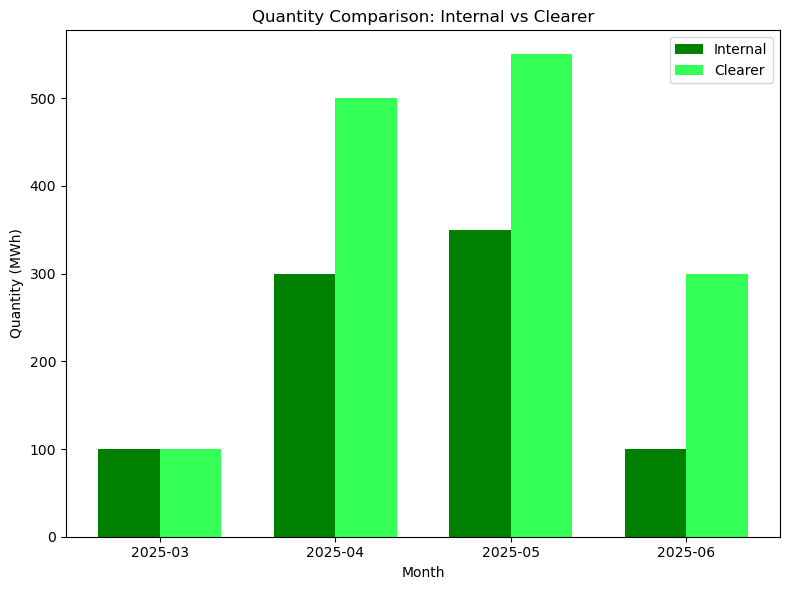

In [25]:
# Quantity comparison
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
x = np.arange(len(reconciliation['contract_period']))
ax.bar(x - width/2, reconciliation['quantity_mwh_internal'], width, label='Internal', color="green") 

ax.bar(x + width/2, reconciliation['quantity_mwh_clearer'], width, label='Clearer', color="#33FF57")
ax.set_xlabel('Month')
ax.set_ylabel('Quantity (MWh)')
ax.set_title('Quantity Comparison: Internal vs Clearer')
ax.set_xticks(x)
ax.set_xticklabels(reconciliation['contract_period'])
ax.legend()
plt.tight_layout()
plt.show()


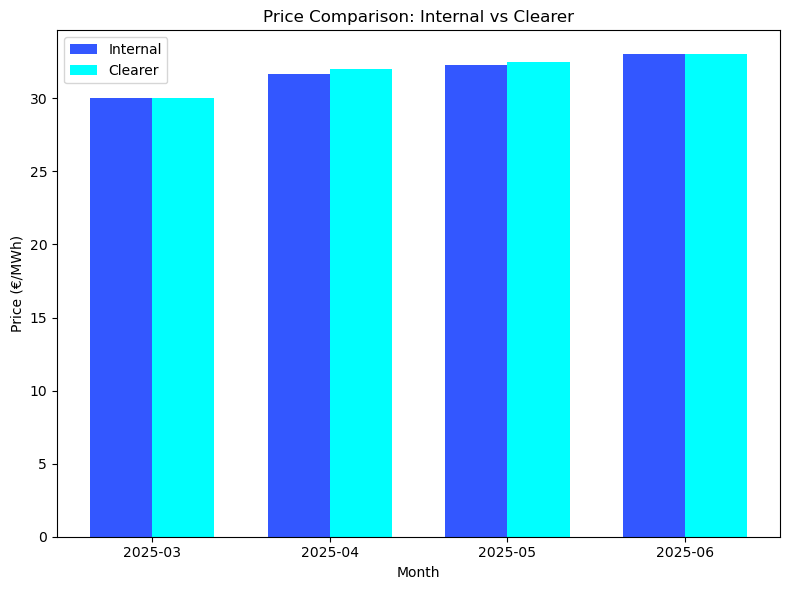

In [31]:
# Price comparison
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, reconciliation['average_price_internal'], width, label='Internal', color='#3357FF')
ax.bar(x + width/2, reconciliation['price_eur_per_mwh_clearer'], width, label='Clearer', color='cyan')
ax.set_xlabel('Month')
ax.set_ylabel('Price (€/MWh)')
ax.set_title('Price Comparison: Internal vs Clearer')
ax.set_xticks(x)
ax.set_xticklabels(reconciliation['contract_period'])
ax.legend()
plt.tight_layout()
plt.show()